In [7]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import numpy as np
import os
import random
import shutil
import cv2
%matplotlib inline

import matplotlib.pyplot as plt


import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchcontrib.optim as tc_optim
import scipy



# 1. Data pre-processing
1. create a trnasformaer which resize and normalize  picture
2. split to train valid and test folders 

In [8]:

# Define the source directory where the 8000 images and vectors are located
source_dir = 'Data/jpg'

# Define the destination root directory where the class folders will be created
destination_root = 'Data/yolov5_pic'

# Create the destination root directory if it does not exist
if not os.path.exists(destination_root):
    os.makedirs(destination_root)

# Read the vector data (assuming it is stored in a list named 'vector_data')
mat_data = scipy.io.loadmat('Data\imagelabels.mat')
vector_data=mat_data['labels'].flatten()
list_of_images=os.listdir('Data/jpg')
# Iterate over each image and its corresponding vector
for i in range(len(vector_data)):
    # Determine the class label based on the vector data (assuming it is a single integer value)
    class_label = vector_data[i]  # Replace with your method of obtaining the class label

    # Create the destination class directory if it does not exist
    class_dir = os.path.join(destination_root, str(class_label))
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    # Copy the image file from the source directory to the corresponding class directory
    image_file = list_of_images[i]  # Replace with your image file naming convention
    shutil.copy(os.path.join(source_dir, image_file), os.path.join(class_dir, image_file))

In [9]:
data_dir = 'Data\yolov5_pic'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Replace with appropriate normalization values
])
dataset = ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## 2.ML implematation
1. split to train validation and test data sets
2. insert the data set to the Dataloader
3. Hyper parameter tuning
4. fit the model with the best learnign rate

In [10]:
#split data to train validation and test
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 0.25
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# Define data loaders for train, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [11]:
# build the architecture of the model
def yolov_5_model(lr_parm=0.001):
    """
    create yolov5 clf model
    params : lr_param- float of learning rate
    return model, optimizer, criterion
    """
    #import the backbone
    backbone = torch.hub.load('ultralytics/yolov5', 'custom', 'yolov5s-cls.pt')
    # Freeze the pre-trained layers
    for param in backbone.parameters():
        param.requires_grad = False
    # Replace the classification head
    num_classes = 103  
    classification_head = nn.Sequential(
        nn.Linear(in_features=1000, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=num_classes)
    )
    model = nn.Sequential(backbone, classification_head)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_parm)
    return model,optimizer,criterion,device

In [44]:
#hyper parameter tuning
learning_rates = [0.0001, 0.0005, 0.001, 0.01]
best_val_accuracy = 0
best_learning_rate = None

for learning_rate in learning_rates:
    train_accuracy_values = []
    val_accuracy_values = []
    train_loss_values = []
    val_loss_values = []
    model, optimizer, criterion, device = yolov_5_model(lr_parm=learning_rate)

    # Training loop
    num_epochs = 7
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_loss_values.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        train_accuracy = 100 * correct / labels.size(0)
        train_accuracy_values.append(train_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        total_correct = 0
        total_samples = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        val_accuracy = 100 * total_correct / total_samples
        val_loss /= len(val_loader)
        val_accuracy_values.append(val_accuracy)
        val_loss_values.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_learning_rate = learning_rate

print("Best learning rate:", best_learning_rate)

Using cache found in C:\Users\galbe/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-22 Python-3.10.9 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Epoch [1/7], Train Loss: 4.0118
Epoch [1/7], Train Accuracy: 33.33%
Epoch [1/7], Validation Accuracy: 34.88%
Epoch [2/7], Train Loss: 2.5663
Epoch [2/7], Train Accuracy: 66.67%
Epoch [2/7], Validation Accuracy: 58.48%
Epoch [3/7], Train Loss: 1.6339
Epoch [3/7], Train Accuracy: 80.00%
Epoch [3/7], Validation Accuracy: 73.82%
Epoch [4/7], Train Loss: 1.1291
Epoch [4/7], Train Accuracy: 90.00%
Epoch [4/7], Validation Accuracy: 79.68%
Epoch [5/7], Train Loss: 0.8487
Epoch [5/7], Train Accuracy: 83.33%
Epoch [5/7], Validation Accuracy: 82.12%
Epoch [6/7], Train Loss: 0.6703
Epoch [6/7], Train Accuracy: 93.33%
Epoch [6/7], Validation Accuracy: 83.49%
Epoch [7/7], Train Loss: 0.5566
Epoch [7/7], Train Accuracy: 90.00%
Epoch [7/7], Validation Accuracy: 84.86%


Using cache found in C:\Users\galbe/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-22 Python-3.10.9 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Epoch [1/7], Train Loss: 2.4750
Epoch [1/7], Train Accuracy: 73.33%
Epoch [1/7], Validation Accuracy: 77.04%
Epoch [2/7], Train Loss: 0.6748
Epoch [2/7], Train Accuracy: 93.33%
Epoch [2/7], Validation Accuracy: 83.00%
Epoch [3/7], Train Loss: 0.3560
Epoch [3/7], Train Accuracy: 90.00%
Epoch [3/7], Validation Accuracy: 86.17%
Epoch [4/7], Train Loss: 0.2252
Epoch [4/7], Train Accuracy: 96.67%
Epoch [4/7], Validation Accuracy: 87.20%
Epoch [5/7], Train Loss: 0.1508
Epoch [5/7], Train Accuracy: 100.00%
Epoch [5/7], Validation Accuracy: 87.64%
Epoch [6/7], Train Loss: 0.1042
Epoch [6/7], Train Accuracy: 100.00%
Epoch [6/7], Validation Accuracy: 89.45%
Epoch [7/7], Train Loss: 0.0761
Epoch [7/7], Train Accuracy: 100.00%
Epoch [7/7], Validation Accuracy: 88.91%


Using cache found in C:\Users\galbe/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-22 Python-3.10.9 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Epoch [1/7], Train Loss: 1.9882
Epoch [1/7], Train Accuracy: 80.00%
Epoch [1/7], Validation Accuracy: 78.16%
Epoch [2/7], Train Loss: 0.4551
Epoch [2/7], Train Accuracy: 80.00%
Epoch [2/7], Validation Accuracy: 85.88%
Epoch [3/7], Train Loss: 0.2287
Epoch [3/7], Train Accuracy: 93.33%
Epoch [3/7], Validation Accuracy: 85.93%
Epoch [4/7], Train Loss: 0.1426
Epoch [4/7], Train Accuracy: 93.33%
Epoch [4/7], Validation Accuracy: 87.74%
Epoch [5/7], Train Loss: 0.0747
Epoch [5/7], Train Accuracy: 100.00%
Epoch [5/7], Validation Accuracy: 88.96%
Epoch [6/7], Train Loss: 0.0450
Epoch [6/7], Train Accuracy: 100.00%
Epoch [6/7], Validation Accuracy: 89.45%
Epoch [7/7], Train Loss: 0.0282
Epoch [7/7], Train Accuracy: 100.00%
Epoch [7/7], Validation Accuracy: 89.06%


Using cache found in C:\Users\galbe/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-22 Python-3.10.9 torch-2.0.1+cpu CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Epoch [1/7], Train Loss: 2.4000
Epoch [1/7], Train Accuracy: 70.00%
Epoch [1/7], Validation Accuracy: 55.35%
Epoch [2/7], Train Loss: 1.1764
Epoch [2/7], Train Accuracy: 73.33%
Epoch [2/7], Validation Accuracy: 65.17%
Epoch [3/7], Train Loss: 0.9427
Epoch [3/7], Train Accuracy: 73.33%
Epoch [3/7], Validation Accuracy: 70.35%
Epoch [4/7], Train Loss: 0.7441
Epoch [4/7], Train Accuracy: 63.33%
Epoch [4/7], Validation Accuracy: 69.17%
Epoch [5/7], Train Loss: 0.7224
Epoch [5/7], Train Accuracy: 80.00%
Epoch [5/7], Validation Accuracy: 73.62%
Epoch [6/7], Train Loss: 0.7879
Epoch [6/7], Train Accuracy: 90.00%
Epoch [6/7], Validation Accuracy: 70.35%
Epoch [7/7], Train Loss: 0.7305
Epoch [7/7], Train Accuracy: 86.67%
Epoch [7/7], Validation Accuracy: 73.38%
Best learning rate: 0.0005


In [14]:
best_learning_rate=0.0005

In [23]:
# Lists to store accuracy and loss values
train_accuracy_values = []
val_accuracy_values = []
test_accuracy_values = []
train_loss_values = []
val_loss_values = []
test_loss_values = []
model,optimizer,criterion,device=yolov_5_model(lr_parm=best_learning_rate)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss_values.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    # Calculate training accuracy
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    train_accuracy = 100 * correct / labels.size(0)
    train_accuracy_values.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    total_correct = 0
    total_samples = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()
        val_accuracy = 100 * total_correct / total_samples
        val_loss /= len(val_loader)
        val_accuracy_values.append(val_accuracy)
        val_loss_values.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%")

    # test- as required, we store the loss and accuracy of each epochs
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()

        test_accuracy = 100 * total_correct / total_samples
        test_loss /= len(test_loader)
        test_accuracy_values.append(test_accuracy)
        test_loss_values.append(test_loss)



Using cache found in C:\Users\galbe/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-6-22 Python-3.10.12 torch-2.0.1 CPU

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING  YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Epoch [1/10], Train Loss: 2.4767
Epoch [1/10], Train Accuracy: 73.33%
Epoch [1/10], Validation Accuracy: 76.65%
Epoch [2/10], Train Loss: 0.6736
Epoch [2/10], Train Accuracy: 80.00%
Epoch [2/10], Validation Accuracy: 84.12%
Epoch [3/10], Train Loss: 0.3652
Epoch [3/10], Train Accuracy: 90.00%
Epoch [3/10], Validation Accuracy: 86.42%
Epoch [4/10], Train Loss: 0.2420
Epoch [4/10], Train Accuracy: 100.00%
Epoch [4/10], Validation Accuracy: 88.42%
Epoch [5/10], Train Loss: 0.1570
Epoch [5/10], Train Accuracy: 100.00%
Epoch [5/10], Validation Accuracy: 89.15%
Epoch [6/10], Train Loss: 0.1166
Epoch [6/10], Train Accuracy: 100.00%
Epoch [6/10], Validation Accuracy: 88.62%
Epoch [7/10], Train Loss: 0.0821
Epoch [7/10], Train Accuracy: 100.00%
Epoch [7/10], Validation Accuracy: 89.89%
Epoch [8/10], Train Loss: 0.0636
Epoch [8/10], Train Accuracy: 100.00%
Epoch [8/10], Validation Accuracy: 89.89%
Epoch [9/10], Train Loss: 0.0454
Epoch [9/10], Train Accuracy: 100.00%
Epoch [9/10], Validation Acc

# 3. Model Evaluation

In [24]:
#test model
torch.save(model.state_dict(), 'trained_model.pt')

# Test
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = 100 * total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 90.33%


In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

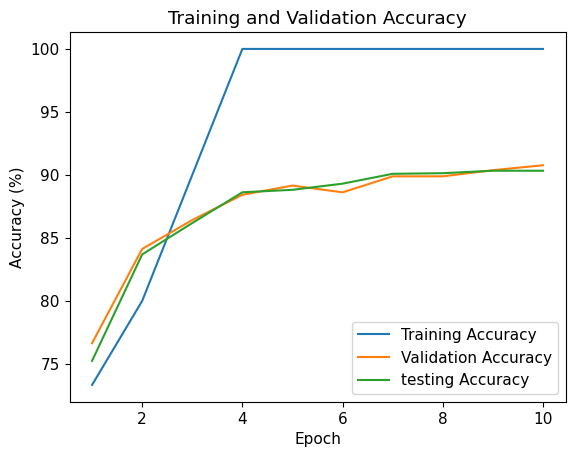

In [25]:
# Plotting training and validation accuracy over epochs
plt.plot(range(1, num_epochs + 1), train_accuracy_values, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_values, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracy_values, label='testing Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



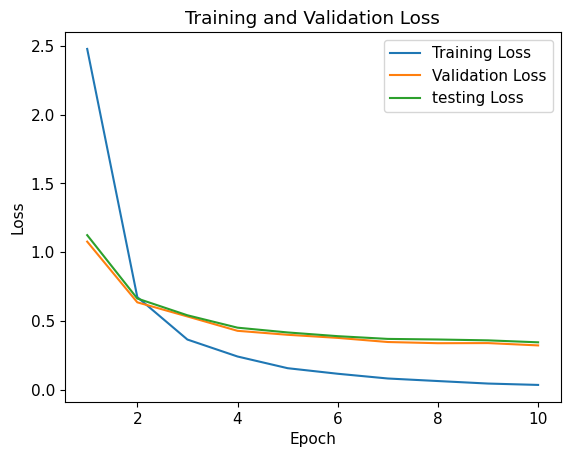

In [26]:
# Plotting training and validation loss over epochs
plt.plot(range(1, num_epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_loss_values, label='testing Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [27]:
test_loss_values

[1.1236924827098846,
 0.6632132977247238,
 0.541476028971374,
 0.4514025191310793,
 0.4167410838417709,
 0.3896828633733094,
 0.3697825373383239,
 0.3655140391783789,
 0.35924722836352885,
 0.345013034529984]